In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crop-diseases-classification/Data/label_num_to_disease_map.json
/kaggle/input/crop-diseases-classification/Data/train.csv
/kaggle/input/crop-diseases-classification/Data/train_images/478554372.jpg
/kaggle/input/crop-diseases-classification/Data/train_images/2763304605.jpg
/kaggle/input/crop-diseases-classification/Data/train_images/2826122413.jpg
/kaggle/input/crop-diseases-classification/Data/train_images/231268038.jpg
/kaggle/input/crop-diseases-classification/Data/train_images/4201965605.jpg
/kaggle/input/crop-diseases-classification/Data/train_images/3224710052.jpg
/kaggle/input/crop-diseases-classification/Data/train_images/2530575673.jpg
/kaggle/input/crop-diseases-classification/Data/train_images/720275537.jpg
/kaggle/input/crop-diseases-classification/Data/train_images/3459977804.jpg
/kaggle/input/crop-diseases-classification/Data/train_images/2174460518.jpg
/kaggle/input/crop-diseases-classification/Data/train_images/4054194563.jpg
/kaggle/input/crop-diseases-cla

In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import json
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation,GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD

2024-05-15 10:31:24.316138: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-15 10:31:24.316251: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-15 10:31:24.482681: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# data upload
df = pd.read_csv("/kaggle/input/crop-diseases-classification/Data/train.csv")
df

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
21392,999068805.jpg,3
21393,999329392.jpg,3
21394,999474432.jpg,1
21395,999616605.jpg,4


In [4]:
# upload label names
with open("/kaggle/input/crop-diseases-classification/Data/label_num_to_disease_map.json", "r") as file:
    label_name = json.load(file)
label_name

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

In [5]:
# path of the images
image_path = "/kaggle/input/crop-diseases-classification/Data/train_images"
image_list = os.listdir(image_path)

In [8]:
# Matching labels with images
df = df[df["image_id"].isin(image_list)]
df.reset_index(drop=True, inplace=True)

In [9]:
# create paths of the image and label
path_name = "/kaggle/input/crop-diseases-classification/Data/train_images/"
df["image_path"] = df["image_id"].apply(lambda x: str(path_name+x))
df["label_name"] = df["label"].apply(lambda x: label_name[str(x)])
df.head()

,image_id,label,image_path,label_name
0,157078263.jpg,3,/kaggle/input/crop-diseases-classification/Dat...,Cassava Mosaic Disease (CMD)
1,1574893536.jpg,3,/kaggle/input/crop-diseases-classification/Dat...,Cassava Mosaic Disease (CMD)
2,1575013487.jpg,3,/kaggle/input/crop-diseases-classification/Dat...,Cassava Mosaic Disease (CMD)
3,1576606254.jpg,0,/kaggle/input/crop-diseases-classification/Dat...,Cassava Bacterial Blight (CBB)
4,1579761476.jpg,1,/kaggle/input/crop-diseases-classification/Dat...,Cassava Brown Streak Disease (CBSD)


In [10]:
from sklearn.model_selection import train_test_split

# train and test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

### ALEXNET MODEL 

In [11]:
#Using Alexnet architecture. input is 227, 227,3 image and output is 5 classes of crobs 
model = tf.keras.models.Sequential([
    #1st Convolutional Layer
    tf.keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    #2nd Convolutional Layer
    tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    #3rd Convolutional Layer
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    #4th Convolutional Layer
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    #5th Convolutional Layer
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    #Passing it to a Fully Connected layer
    tf.keras.layers.Flatten(),
    # 1st Fully Connected Layer
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),# Add Dropout to prevent overfitting
    # 2nd Fully Connected Layer
    tf.keras.layers.Dense(4096, activation='relu'),
    #tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.Dropout(0.5),
    # 3rd Fully Connected Layer
    tf.keras.layers.Dense(1000, activation='relu'),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    #Output Layer
    tf.keras.layers.Dense(5, activation='softmax'),
    #tf.keras.layers.BatchNormalization()
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [12]:
model.compile(
    optimizer=tf.optimizers.SGD(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=["accuracy"]
)

In [13]:
#Getting model's summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 55, 55, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 55, 55, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 27, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 27, 27, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 13, 13, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 384)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 384)      │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 6, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4096)           │        16,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1000)           │     4,097,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         5,005 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,405,237 (238.06 MB)

 Trainable params: 62,394,293 (238.02 MB)

 Non-trainable params: 10,944 (42.75 KB)

In [14]:
#Specifing epochs & batch size for alexnet
epochs = 40
batch_size = 32
image_height = 227
image_width = 227

In [15]:
#Creating an object of ImageDataGenerator for augmenting training dataset
train_datagen = ImageDataGenerator(rescale= 1./255,
rotation_range=10,
width_shift_range=0.1,
height_shift_range=0.1,
shear_range=0.1,
zoom_range=0.1,
horizontal_flip=True,
fill_mode='nearest')

#Creating an object of ImageDataGenerator for augmenting test dataset
test_datagen = ImageDataGenerator(rescale= 1./255)

In [16]:
# train_datagen for alexnet
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="image_path",
    y_col="label_name",
    target_size=(image_height, image_width),
    batch_size=batch_size,
    color_mode= "rgb",
    class_mode="categorical"
)

# test_datagen for alexnet
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="image_path",
    y_col="label_name",
    target_size=(image_height, image_width),
    batch_size=batch_size,
    color_mode= "rgb",
    class_mode="categorical"
)

# Get sample numbers for fit and validation
nb_train_samples = train_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())

Found 14350 validated image filenames belonging to 5 classes.
Found 3588 validated image filenames belonging to 5 classes.


In [34]:
# Model fit
history = model.fit(train_generator, epochs=50, validation_data=test_generator)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/449 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - accuracy: 0.1328 - loss: 2.8670   

W0000 00:00:1714920934.452764      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 71/449 ━━━━━━━━━━━━━━━━━━━━ 3:52 614ms/step - accuracy: 0.2239 - loss: 2.5081

W0000 00:00:1714920977.367187      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.3928 - loss: 2.0350

W0000 00:00:1714921173.067787      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


449/449 ━━━━━━━━━━━━━━━━━━━━ 269s 577ms/step - accuracy: 0.3930 - loss: 2.0345 - val_accuracy: 0.4897 - val_loss: 1.3499
Epoch 2/50


W0000 00:00:1714921193.075310      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


449/449 ━━━━━━━━━━━━━━━━━━━━ 252s 552ms/step - accuracy: 0.5051 - loss: 1.6391 - val_accuracy: 0.5011 - val_loss: 1.3301
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 254s 557ms/step - accuracy: 0.5217 - loss: 1.5851 - val_accuracy: 0.5702 - val_loss: 1.2213
Epoch 4/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 258s 565ms/step - accuracy: 0.5359 - loss: 1.5171 - val_accuracy: 0.6179 - val_loss: 1.1420
Epoch 5/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 261s 572ms/step - accuracy: 0.5517 - loss: 1.4572 - val_accuracy: 0.5329 - val_loss: 1.3038
Epoch 6/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 263s 575ms/step - accuracy: 0.5523 - loss: 1.4477 - val_accuracy: 0.3676 - val_loss: 1.6368
Epoch 7/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 258s 566ms/step - accuracy: 0.5545 - loss: 1.4074 - val_accuracy: 0.5006 - val_loss: 1.3051
Epoch 8/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 256s 562ms/step - accuracy: 0.5613 - loss: 1.3684 - val_accuracy: 0.6207 - val_loss: 1.1868
Epoch 9/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 261s 572ms/step - accuracy: 0.5652 - loss: 1.35

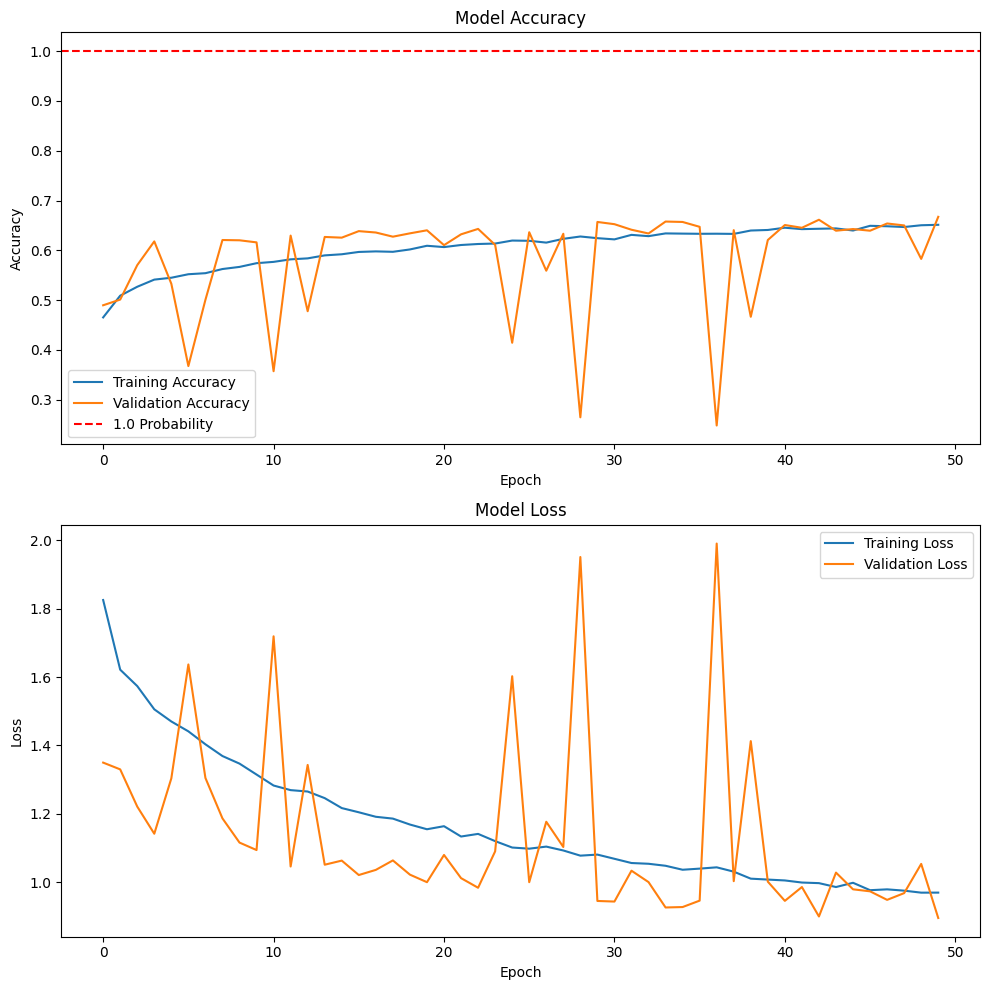

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

# Plotting the model accuracy
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=1, color='r', linestyle='--', label='1.0 Probability')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting the model loss
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()  
plt.show()


In [36]:
from sklearn.metrics import classification_report

# predictions from the test data
y_pred = model.predict(test_generator)

# transform class labels of the predictions
y_pred_classes = np.argmax(y_pred, axis=1)

# Real classes
y_true = test_generator.classes

# create classification report
report = classification_report(y_true, y_pred_classes, target_names=classes)

# print report
print(report)

  3/113 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step

W0000 00:00:1714934118.735110      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/113 ━━━━━━━━━━━━━━━━━━━━ 19s 156ms/step
                                     precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.06      0.05      0.05       196
Cassava Brown Streak Disease (CBSD)       0.08      0.04      0.05       385
         Cassava Green Mottle (CGM)       0.09      0.05      0.06       397
       Cassava Mosaic Disease (CMD)       0.61      0.76      0.68      2194
                            Healthy       0.10      0.07      0.08       416

                           accuracy                           0.48      3588
                          macro avg       0.19      0.19      0.18      3588
                       weighted avg       0.41      0.48      0.44      3588



W0000 00:00:1714934136.242190      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


### VGGNET MODEL

In [18]:
vgg16_model = tf.keras.models.Sequential([
    # Block 1
    tf.keras.layers.Conv2D(64, (3, 3), (1,1), activation='relu', padding='same',input_shape=(224,224,3)),
    tf.keras.layers.Conv2D(64, (3, 3), (1,1), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),

    # Block 2
    tf.keras.layers.Conv2D(128, (3, 3), (1,1), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), (1,1), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),

    # Block 3
    tf.keras.layers.Conv2D(256, (3, 3), (1,1), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, (3, 3), (1,1), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, (3, 3), (1,1), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),

    # Block 4
    tf.keras.layers.Conv2D(512, (3, 3), (1,1), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(512, (3, 3), (1,1), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(512, (3, 3), (1,1), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),

    # Block 5
    tf.keras.layers.Conv2D(512, (3, 3), (1,1), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(512, (3, 3), (1,1), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(512, (3, 3), (1,1), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),

    # Fully connected layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax')
])


In [19]:
vgg16_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=["accuracy"]
)

In [20]:
#Getting model's summary
vgg16_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 28, 28, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 14, 14, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 134,303,301 (512.33 MB)

 Trainable params: 134,292,165 (512.28 MB)

 Non-trainable params: 11,136 (43.50 KB)

In [21]:
#Specifing epochs & batch size for vggnet16
epochs = 40
batch_size = 32
image_height = 224
image_width = 224

In [22]:
# train_datagen for vggnet
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="image_path",
    y_col="label_name",
    target_size=(image_height, image_width),
    batch_size=batch_size,
    color_mode= "rgb",
    class_mode="categorical"
)
# test_datagen for vggnet
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="image_path",
    y_col="label_name",
    target_size=(image_height, image_width),
    batch_size=batch_size,
    color_mode= "rgb",
    class_mode="categorical"
)

# Get sample numbers for fit and validation
nb_train_samples = train_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())

Found 14350 validated image filenames belonging to 5 classes.
Found 3588 validated image filenames belonging to 5 classes.


In [23]:
# vgg16_model fit 
vgg16_history = vgg16_model.fit(train_generator, epochs=epochs, validation_data=test_generator)

Epoch 1/40


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1715440470.156184     120 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715440470.187608     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


167/449 ━━━━━━━━━━━━━━━━━━━━ 3:15 692ms/step - accuracy: 0.4280 - loss: 1.9521

W0000 00:00:1715440631.520940     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - accuracy: 0.4518 - loss: 1.8987

W0000 00:00:1715440826.844695     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


449/449 ━━━━━━━━━━━━━━━━━━━━ 493s 903ms/step - accuracy: 0.4519 - loss: 1.8986 - val_accuracy: 0.3765 - val_loss: 1.5538
Epoch 2/40


W0000 00:00:1715440874.955318     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


449/449 ━━━━━━━━━━━━━━━━━━━━ 244s 535ms/step - accuracy: 0.4951 - loss: 1.7777 - val_accuracy: 0.6168 - val_loss: 1.5048
Epoch 3/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 245s 537ms/step - accuracy: 0.4987 - loss: 1.7411 - val_accuracy: 0.5839 - val_loss: 1.2686
Epoch 4/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 240s 527ms/step - accuracy: 0.5256 - loss: 1.6566 - val_accuracy: 0.5385 - val_loss: 1.2608
Epoch 5/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 239s 524ms/step - accuracy: 0.5264 - loss: 1.6478 - val_accuracy: 0.6165 - val_loss: 1.2204
Epoch 6/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 238s 522ms/step - accuracy: 0.5330 - loss: 1.5783 - val_accuracy: 0.5833 - val_loss: 1.1806
Epoch 7/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 241s 529ms/step - accuracy: 0.5336 - loss: 1.6014 - val_accuracy: 0.5700 - val_loss: 1.1964
Epoch 8/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 239s 524ms/step - accuracy: 0.5508 - loss: 1.5229 - val_accuracy: 0.6279 - val_loss: 1.1760
Epoch 9/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 240s 526ms/step - accuracy: 0.5437 - loss: 1.53

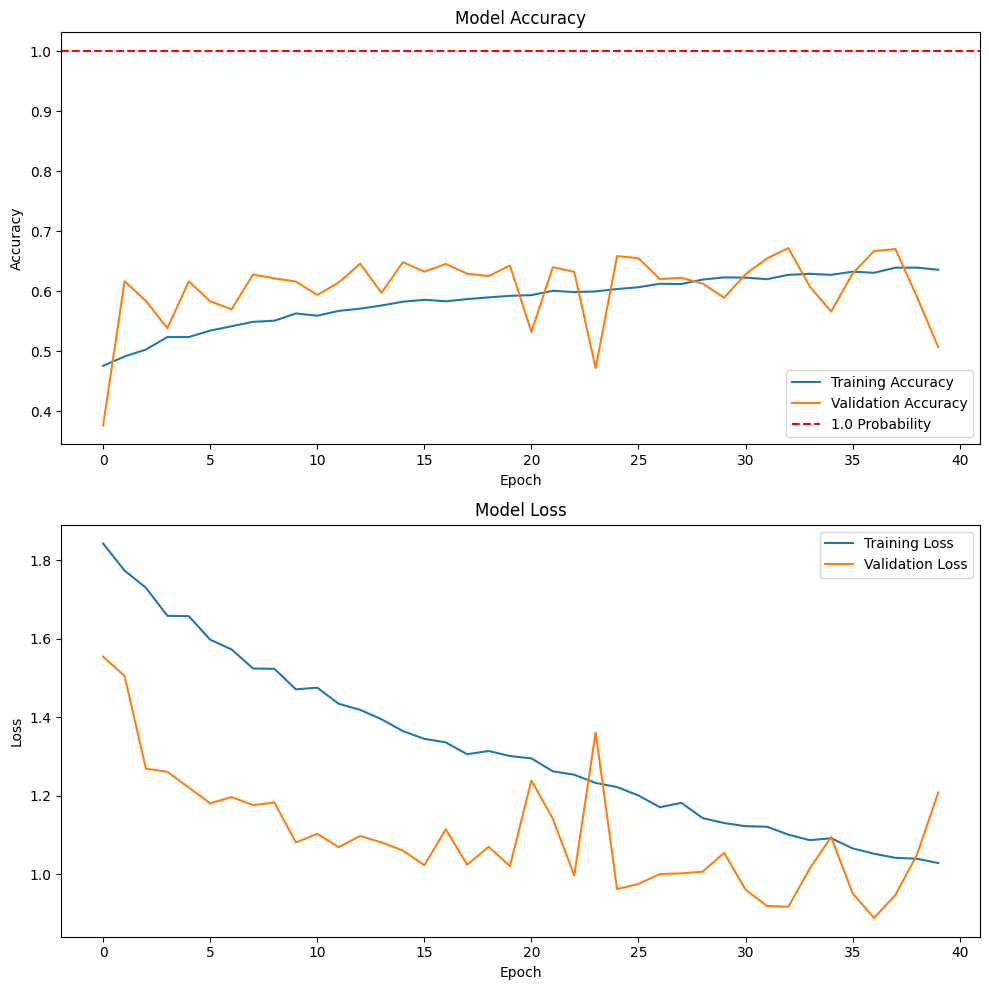

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

# accuracy
plt.subplot(2, 1, 1)
plt.plot(vgg16_history.history['accuracy'], label='Training Accuracy')
plt.plot(vgg16_history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=1, color='r', linestyle='--', label='1.0 Probability')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# loss
plt.subplot(2, 1, 2)
plt.plot(vgg16_history.history['loss'], label='Training Loss')
plt.plot(vgg16_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()  
plt.show()


In [25]:
from sklearn.metrics import classification_report

# predictions from the test data
y_pred = vgg16_model.predict(test_generator)

# transform class labels of the predictions
y_pred_classes = np.argmax(y_pred, axis=1)

# Real classes
y_true = test_generator.classes

# Create classification report
report = classification_report(y_true, y_pred_classes, target_names=classes)

# print report
print(report)

  2/113 ━━━━━━━━━━━━━━━━━━━━ 17s 162ms/step

W0000 00:00:1715450352.949799     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 166ms/step
                                     precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.07      0.13      0.09       196
Cassava Brown Streak Disease (CBSD)       0.13      0.07      0.09       385
         Cassava Green Mottle (CGM)       0.12      0.13      0.13       397
       Cassava Mosaic Disease (CMD)       0.61      0.39      0.48      2194
                            Healthy       0.12      0.34      0.17       416

                           accuracy                           0.31      3588
                          macro avg       0.21      0.21      0.19      3588
                       weighted avg       0.42      0.31      0.34      3588



W0000 00:00:1715450371.582826     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


### RESNET MODEL

In [22]:
import tensorflow as tf
from tensorflow.keras import layers

def residual_block(x, filters, downsample=False):
    if downsample:
        strides = 2
    else:
        strides = 1

    identity = x

    x = layers.Conv2D(filters=filters, kernel_size=3, strides=strides, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters=filters, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    if downsample:
        identity = layers.Conv2D(filters=filters, kernel_size=1, strides=2, padding='same')(identity)
        identity = layers.BatchNormalization()(identity)

    x = layers.Add()([x, identity])
    x = layers.ReLU()(x)
    
    return x

def ResNet18(input_shape=(224, 224, 3), num_classes=5): 
    inputs = tf.keras.Input(shape=input_shape)
    
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)
    
    x = residual_block(x, filters=128, downsample=True)
    x = residual_block(x, filters=128)

    x = residual_block(x, filters=256, downsample=True)
    x = residual_block(x, filters=256)

    x = residual_block(x, filters=512, downsample=True)
    x = residual_block(x, filters=512)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

# Create model
resnet18_model = ResNet18()


In [33]:
resnet18_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=["accuracy"]
)

In [34]:
resnet18_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 112, 112,  │      9,472 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 56, 56,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 56, 56,    │     36,928 │ max_pooling2d_8[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 56, 56,    │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 56, 56,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 56, 56,    │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 56, 56,    │     36,928 │ re_lu_3[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_22[0][0] 

 Total params: 11,193,477 (42.70 MB)

 Trainable params: 11,183,877 (42.66 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [35]:
#Specifing epochs & batch size for resnet
epochs = 20
batch_size = 32
image_height = 224
image_width = 224

In [26]:
# train_datagen for resnet
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="image_path",
    y_col="label_name",
    target_size=(image_height, image_width),
    batch_size=batch_size,
    color_mode= "rgb",
    class_mode="categorical"
)
# test_datagen for resnet
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="image_path",
    y_col="label_name",
    target_size=(image_height, image_width),
    batch_size=batch_size,
    color_mode= "rgb",
    class_mode="categorical"
)

# Get sample numbers for fit and validation
nb_train_samples = train_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())

Found 14350 validated image filenames belonging to 5 classes.
Found 3588 validated image filenames belonging to 5 classes.


In [36]:
# renset18 model fit 
resnet18_history = resnet18_model.fit(train_generator, epochs=epochs, validation_data=test_generator)

Epoch 1/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 281s 595ms/step - accuracy: 0.7814 - loss: 0.5910 - val_accuracy: 0.7336 - val_loss: 0.6966
Epoch 2/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 258s 566ms/step - accuracy: 0.7944 - loss: 0.5562 - val_accuracy: 0.7598 - val_loss: 0.6312
Epoch 3/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 258s 567ms/step - accuracy: 0.8002 - loss: 0.5504 - val_accuracy: 0.7625 - val_loss: 0.6193
Epoch 4/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 256s 562ms/step - accuracy: 0.8020 - loss: 0.5455 - val_accuracy: 0.7600 - val_loss: 0.6381
Epoch 5/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 257s 564ms/step - accuracy: 0.8010 - loss: 0.5465 - val_accuracy: 0.7698 - val_loss: 0.6066
Epoch 6/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 259s 568ms/step - accuracy: 0.8018 - loss: 0.5487 - val_accuracy: 0.7522 - val_loss: 0.6611
Epoch 7/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 257s 563ms/step - accuracy: 0.8007 - loss: 0.5543 - val_accuracy: 0.7653 - val_loss: 0.6136
Epoch 8/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 257s 563ms/step - accuracy: 0.8025 -

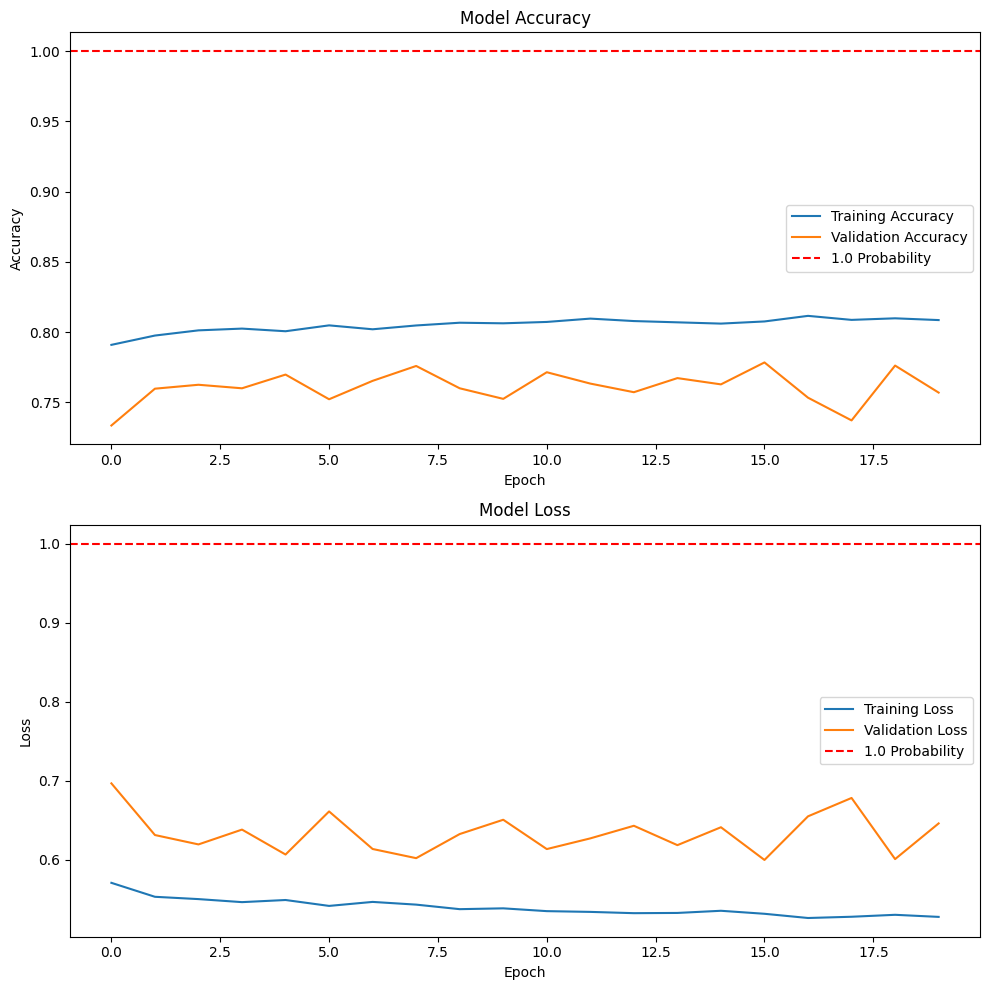

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

# accuracy
plt.subplot(2, 1, 1)
plt.plot(resnet18_history.history['accuracy'], label='Training Accuracy')
plt.plot(resnet18_history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=1, color='r', linestyle='--', label='1.0 Probability')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# loss
plt.subplot(2, 1, 2)
plt.plot(resnet18_history.history['loss'], label='Training Loss')
plt.plot(resnet18_history.history['val_loss'], label='Validation Loss')
plt.axhline(y=1, color='r', linestyle='--', label='1.0 Probability')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [40]:
from sklearn.metrics import classification_report

# predictions from the test data
y_pred = resnet18_model.predict(test_generator)

# transform class labels of the predictions
y_pred_classes = np.argmax(y_pred, axis=1)

# Real Sınıflar
y_true = test_generator.classes

# Create classification report 
report = classification_report(y_true, y_pred_classes, target_names=classes)

# print report
print(report)

113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 173ms/step
                                     precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.05      0.03      0.04       196
Cassava Brown Streak Disease (CBSD)       0.13      0.15      0.14       385
         Cassava Green Mottle (CGM)       0.13      0.12      0.13       397
       Cassava Mosaic Disease (CMD)       0.61      0.59      0.60      2194
                            Healthy       0.12      0.14      0.13       416

                           accuracy                           0.41      3588
                          macro avg       0.21      0.21      0.21      3588
                       weighted avg       0.42      0.41      0.41      3588



### GOOGLENET MODEL

In [30]:
from tensorflow.keras.applications import InceptionV3

# import googlenet with pretrained model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# frozen the all layers
for layer in base_model.layers:
    layer.trainable = False

# add full connected layers 
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(5, activation='softmax')(x)

In [31]:
# Model
googlenet_model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

In [32]:
googlenet_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=["accuracy"]
)

In [33]:
googlenet_model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_193 (Conv2D) │ (None, 111, 111,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d_193[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_188      │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_194 (Conv2D) │ (None, 109, 109,  │      9,216 │ activation_188[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_194[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_189      │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_195 (Conv2D) │ (None, 109, 109,  │     18,432 │ activation_189[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_195[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_190      │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 54, 54,    │          0 │ activation_190[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_196 (Conv2D) │ (None, 54, 54,    │      5,120 │ max_pooling2d_11… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_196[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_191      │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_197 (Conv2D) │ (None, 52, 52,    │    138,240 │ activation_191[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_197[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_192      │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 23,906,085 (91.19 MB)

 Trainable params: 2,103,301 (8.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [35]:
#Specifing epochs & batch size for googlenet
epochs = 40
batch_size = 32
image_height = 224
image_width = 224

In [28]:
# train_datagen for googlenet
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="image_path",
    y_col="label_name",
    target_size=(image_height, image_width),
    batch_size=batch_size,
    color_mode= "rgb",
    class_mode="categorical"
)
# test_datagen for googlenet
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="image_path",
    y_col="label_name",
    target_size=(image_height, image_width),
    batch_size=batch_size,
    color_mode= "rgb",
    class_mode="categorical"
)

# Get sample numbers for fit and validation
nb_train_samples = train_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())

Found 14350 validated image filenames belonging to 5 classes.
Found 3588 validated image filenames belonging to 5 classes.


In [37]:
# Model fit
googlenet_model.fit(train_generator, epochs=40, validation_data=test_generator)

Epoch 1/40
372/449 ━━━━━━━━━━━━━━━━━━━━ 35s 468ms/step - accuracy: 0.6082 - loss: 1.2424

W0000 00:00:1715772611.628869     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.6086 - loss: 1.2396

W0000 00:00:1715772650.600128     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


449/449 ━━━━━━━━━━━━━━━━━━━━ 238s 523ms/step - accuracy: 0.6086 - loss: 1.2395 - val_accuracy: 0.6115 - val_loss: 1.2013
Epoch 2/40


W0000 00:00:1715772672.825224     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


449/449 ━━━━━━━━━━━━━━━━━━━━ 213s 467ms/step - accuracy: 0.6089 - loss: 1.1871 - val_accuracy: 0.6140 - val_loss: 1.1642
Epoch 3/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 215s 471ms/step - accuracy: 0.6257 - loss: 1.1190 - val_accuracy: 0.6159 - val_loss: 1.1378
Epoch 4/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 213s 468ms/step - accuracy: 0.6237 - loss: 1.1046 - val_accuracy: 0.6198 - val_loss: 1.1176
Epoch 5/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 213s 468ms/step - accuracy: 0.6146 - loss: 1.1044 - val_accuracy: 0.6215 - val_loss: 1.0952
Epoch 6/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 215s 471ms/step - accuracy: 0.6276 - loss: 1.0682 - val_accuracy: 0.6243 - val_loss: 1.0826
Epoch 7/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 216s 475ms/step - accuracy: 0.6248 - loss: 1.0695 - val_accuracy: 0.6276 - val_loss: 1.0704
Epoch 8/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 216s 475ms/step - accuracy: 0.6391 - loss: 1.0248 - val_accuracy: 0.6299 - val_loss: 1.0597
Epoch 9/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 214s 470ms/step - accuracy: 0.6311 - loss: 1.03

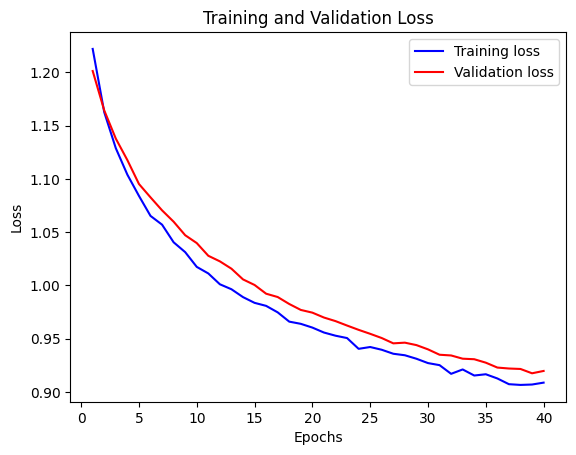

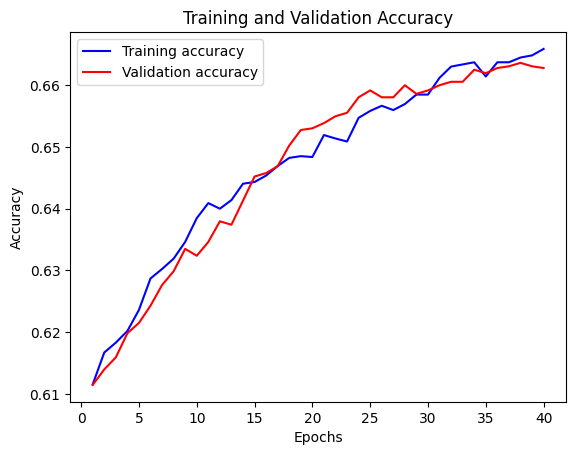

In [41]:
import matplotlib.pyplot as plt

history = googlenet_model.history.history

train_loss = history['loss']
val_loss = history['val_loss']

train_acc = history['accuracy']
val_acc = history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

# loss
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# accuracy
plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [42]:
from sklearn.metrics import classification_report

# predictions from the test data
y_pred = googlenet_model.predict(test_generator)

# transform class labels of the predictions
y_pred_classes = np.argmax(y_pred, axis=1)

# Real classes
y_true = test_generator.classes

# Create classification report
report = classification_report(y_true, y_pred_classes, target_names=classes)

# Print report
print(report)

  3/113 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step

W0000 00:00:1715781525.727817     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/113 ━━━━━━━━━━━━━━━━━━━━ 31s 224ms/step
                                     precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.06      0.03      0.04       196
Cassava Brown Streak Disease (CBSD)       0.12      0.09      0.10       385
         Cassava Green Mottle (CGM)       0.13      0.04      0.06       397
       Cassava Mosaic Disease (CMD)       0.61      0.76      0.68      2194
                            Healthy       0.10      0.09      0.09       416

                           accuracy                           0.49      3588
                          macro avg       0.21      0.20      0.19      3588
                       weighted avg       0.42      0.49      0.45      3588



W0000 00:00:1715781550.797040     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
